In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import seaborn as sns
import cebra
from cebra import CEBRA

from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels
from plotting import subplot_confusion_matrix
from constants import AUDIO_BLOCKS
from features.constants import Feature, MARKER_TO_FEATURE

data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [2]:
from biomarkers import EEG_CHANEL_NAMES
from labels import get_raw_labels, get_label_means
from feature_extraction import EEG_BANDS
from resample.resample import (
    get_validation_indexes,
)


def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]

## Load data and process features

### Slicing

In [3]:
import os

marker = "EEG"
num_slice_per_trial = 5

# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subject_list = []
valence_labels, arousal_labels, attention_labels = [], [], []
label_thresholds = []
for d in os.listdir(data_dir):    
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    vl, arl, atl = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)
    
    subject_list.append(d)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    attention_labels.append(atl)
    label_thresholds.append(get_label_means(subject_data))

Loading ../CleandDataV2/2040 data...
Loading ../CleandDataV2/2013 data...
Loading ../CleandDataV2/2022 data...
Loading ../CleandDataV2/2025 data...
Loading ../CleandDataV2/2046 data...
Loading ../CleandDataV2/2041 data...
Loading ../CleandDataV2/2024 data...
Loading ../CleandDataV2/2012 data...
Loading ../CleandDataV2/2037 data...
Loading ../CleandDataV2/2001 data...
Loading ../CleandDataV2/2039 data...
Loading ../CleandDataV2/2006 data...
Loading ../CleandDataV2/2038 data...
Loading ../CleandDataV2/2007 data...
Loading ../CleandDataV2/2000 data...
Loading ../CleandDataV2/2009 data...
Loading ../CleandDataV2/2036 data...
Loading ../CleandDataV2/2031 data...
Loading ../CleandDataV2/2017 data...
Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2010 data...
Loading ../CleandDataV2/2026 data...
Loading ../CleandDataV2/2019 data...
Loading ../CleandDataV2/2021 data...
Loading ../CleandDataV2/2044 data...
Loading ../CleandDataV2/2043 data...
Loading ../CleandDataV2/2020 data...
L

In [5]:
import pickle

# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
len(marker_features)

41

In [6]:
IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
    "lvha": "blue",
    "lvla": "steelblue",
}
target_names = ['hvha', 'hvla', 'nvha', 'nvla']

cat_labels = []
for idx, (v_thred, a_thred) in enumerate(label_thresholds):
    vc = [ 'hv' if l > v_thred else 'nv' for l in valence_labels[idx]]
    ac = [ 'ha' if l > a_thred else 'la' for l in arousal_labels[idx]]
    vac = [ IDX_MAP[vc[i]+ac[i]] for i in range(len(vc))]
    cat_labels.append(vac)
len(cat_labels)

41

2035


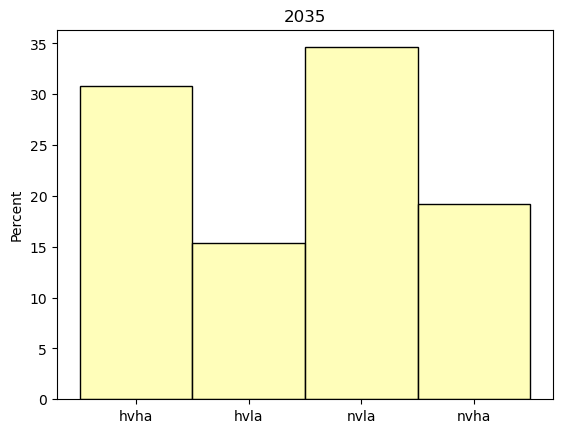

In [115]:
print(subject_list[-1])
for i in range(len(subject_list)):
    if subject_list[i] == '2035':
        g = sns.histplot(data=[target_names[a]for a in cat_labels[i]], stat='percent', color='#fffea3')
        g.set_title('2035')
        

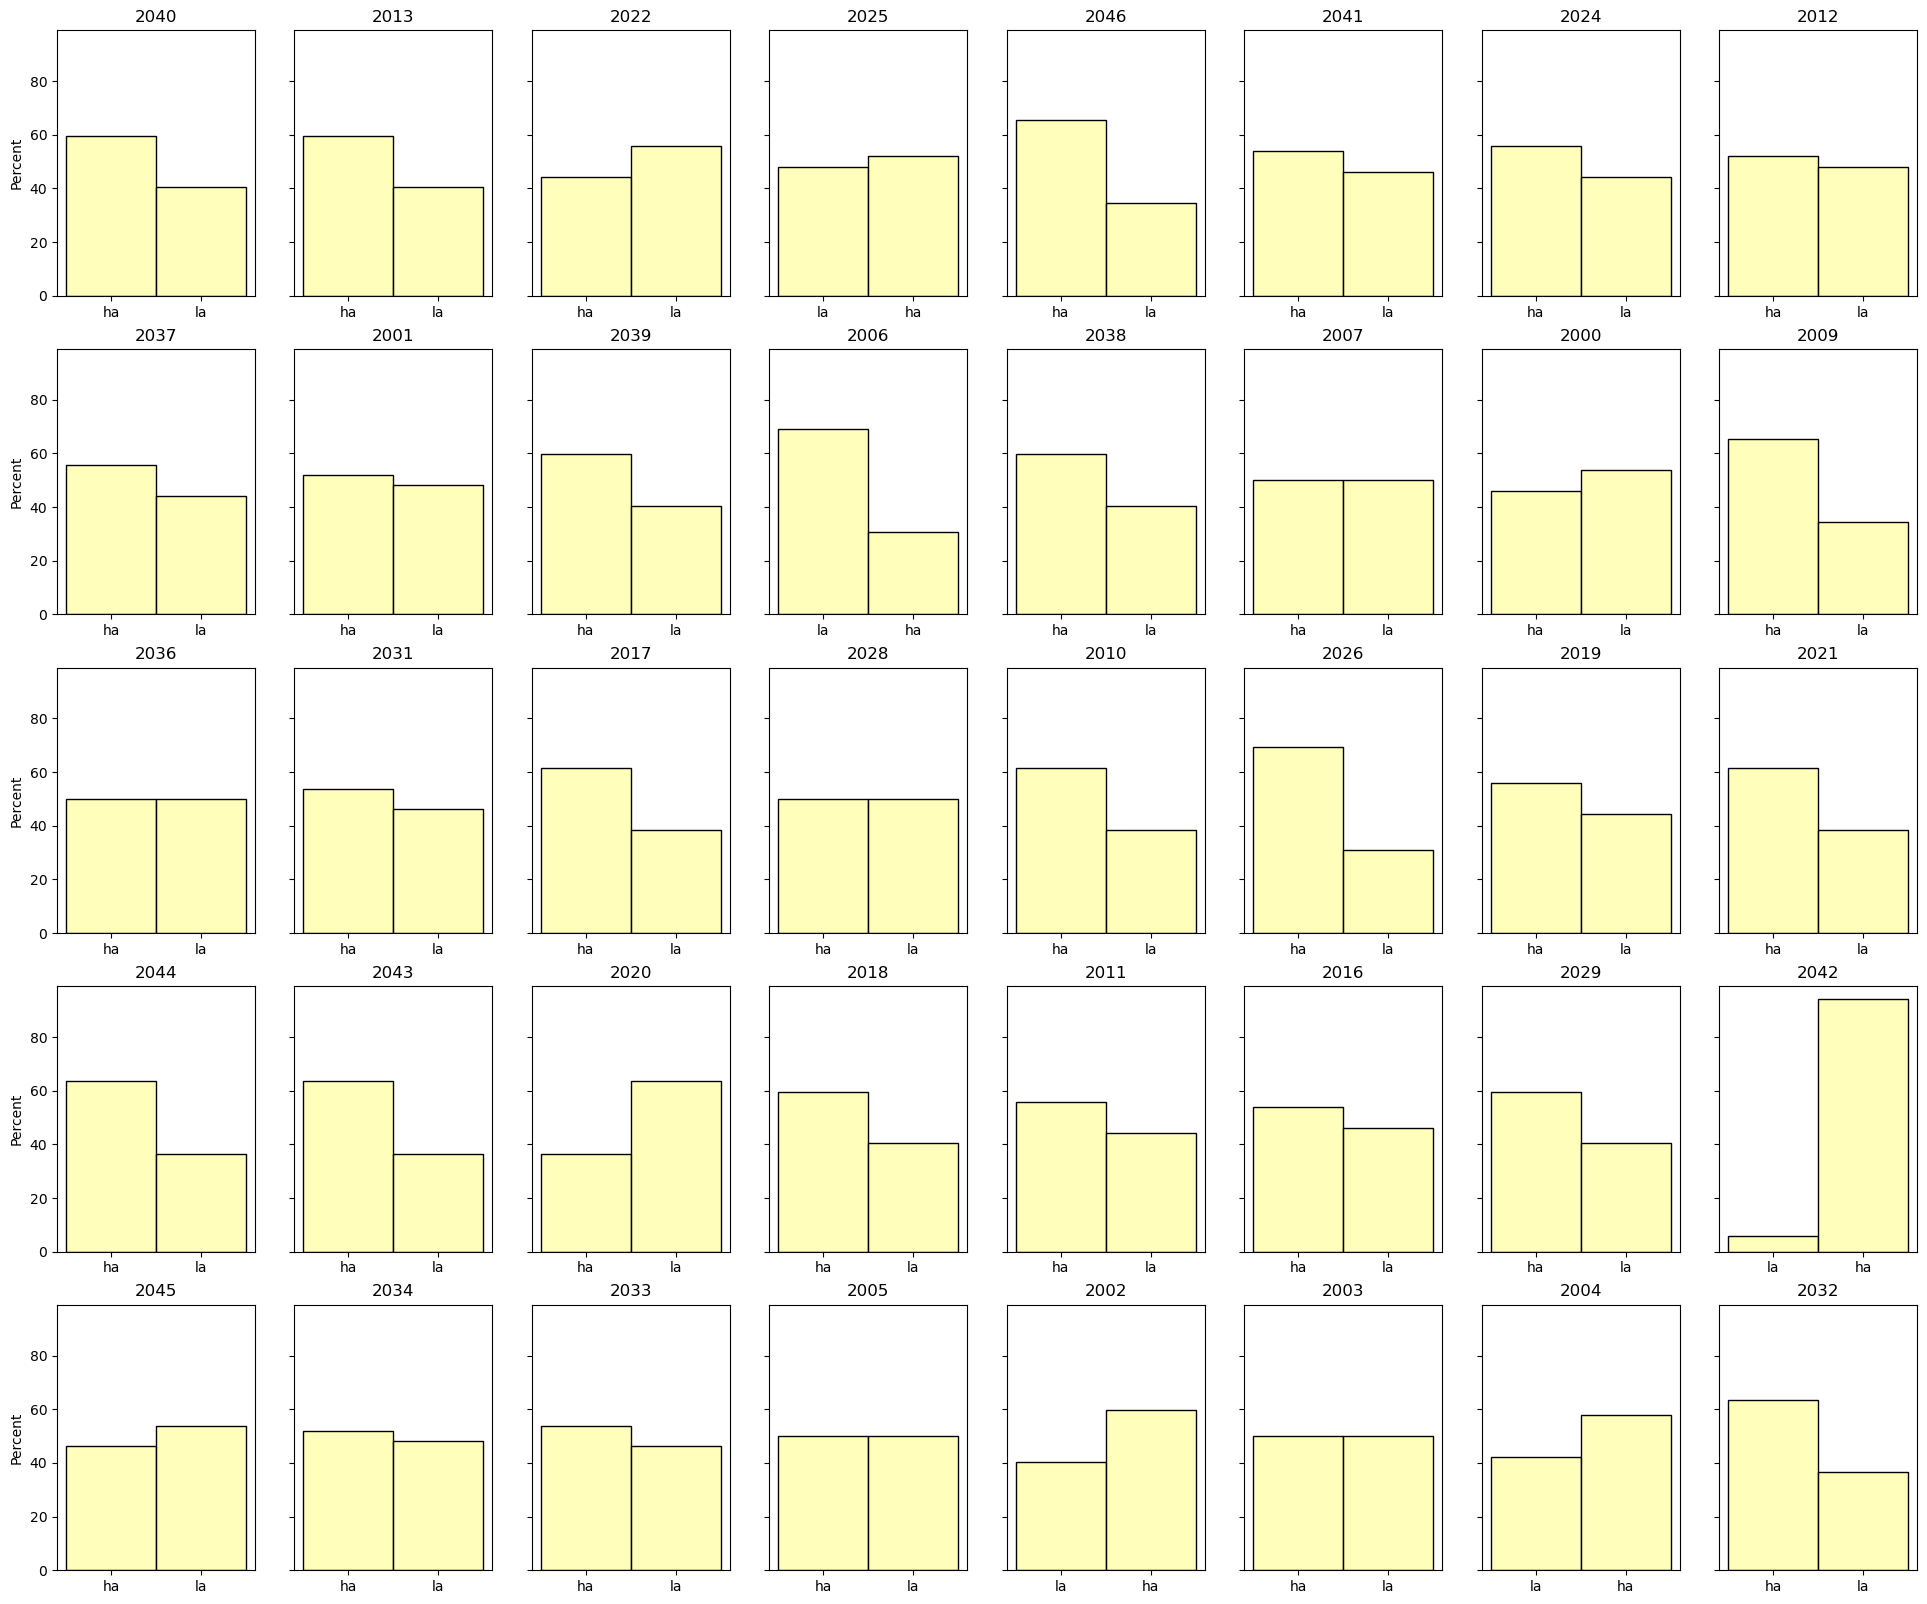

In [116]:
nrows = 5
ncol = 8
fig, axes = plt.subplots(
    nrows=nrows,
    sharey=True,
    ncols=ncol,
    figsize=(ncol * 3, nrows * 4),
)

for i in range(len(axes.flat)):
    g = sns.histplot(
        data=['ha' if 'ha' in target_names[a] else 'la' for a in cat_labels[i]],
        stat="percent",
        ax=axes.flat[i],
        color="#fffea3",
    )
    g.set_title(subject_list[i])

In [59]:
# @title One Over Rest distribution and ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Plots the Probability Distributions and the ROC Curves One vs Rest
bins = [i/20 for i in range(20)] + [1]

def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def _plot_one_over_rest_roc(y_true, y_pred, method, label_type):
  from sklearn.metrics import ConfusionMatrixDisplay
  title = f'{method}:{label_type}'
  # Compuate the confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
      y_true,
      np.argmax(y_pred, axis=1),
      display_labels=target_names,
      cmap=plt.cm.Blues,
      normalize='true')
  # Set the fixed color bar range
  disp.im_.set_clim(0, 1)
  disp.ax_.set_title(title)
  
  y_true_one_hot = one_hot(y_true, len(target_names))

  plt.figure(figsize = (12, 8))
  roc_auc_ovr = {}
  for i in range(len(target_names)):
      c = target_names[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = {}
      df_aux['class'] = y_true_one_hot[:, i]
      df_aux['prob'] = y_pred[:, i]

      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, len(target_names), i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")

      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, len(target_names), i+5)
      RocCurveDisplay.from_predictions(
          df_aux['class'],
          df_aux['prob'],
          name=c,
          #color=color,
          ax=ax_bottom,
          #plot_chance_level=(class_id == 2),
      )
      #tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      #plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title(f"ROC Curve OvR for {c}")

      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
      
      plt.tight_layout()
  plt.title(title)      

## Model Training

### Training utils

In [94]:
import ipywidgets as widgets
from plotting import (
    plot_roc_curve,
    plot_embeddings,
    umap_visualization,
    tsne_visualization,
)
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score

# from importlib import reload
# import features.constants

# reload(features.constants)
from model.embedding import get_embeddings

# CEBRA AND PCA hyper-parameters
OUTPUT_DIM = 6
MAX_HIDDEN_UNITS = 256


def _train_test_split(data, labels, val_indexes: list = []):
    if len(val_indexes) == 0:
        val_indexes = get_validation_indexes()

    train_indexes = list(set(range(len(labels))) - set(val_indexes))
    train_labels = np.array(labels)[train_indexes]
    train_data = data[train_indexes]

    val_data = data[val_indexes]
    val_label = np.array(labels)[val_indexes]
    return train_data, train_labels, val_data, val_label


# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    output_dim,
    max_hidden_units,
):
    from sklearn.neighbors import KNeighborsClassifier

    y_pred, all_embeddings = [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim=6 if method == "PCA" else output_dim,
            num_hidden_units=max_hidden_units,
        )
        all_embeddings.append(embedding)
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = KNeighborsClassifier()
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict_proba(val_embedding)
        y_pred.append(prediction)

    return y_pred, all_embeddings


def get_all_spectral_features(feature_to_data: dict, val_indexes, labels):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def get_all_channel_features(data: dict, val_indexes, labels):
    all_spetral_psd = []
    for _, feature_to_data in data.items():
        spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
        all_spetral_psd.extend(spetral_psd)

    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def prepare_dataset(
    data,
    val_indexes,
    labels,
):
    dataset_dict = {k: {} for k in data.keys()}
    for channel, feature_to_data in data.items():
        for f, neural_data in feature_to_data.items():
            # Prepare the data
            dataset_dict[channel][f] = [
                _train_test_split(neural_data, labels, val_indexes[i])
                for i in range(len(val_indexes))
            ]

        dataset_dict[channel][Feature.ALL_SPECTRAL.name] = get_all_spectral_features(
            feature_to_data, val_indexes, labels
        )

    return dataset_dict


def decode_marker_data(
    dataset_dict,
    method,
    filtered_channel: str = "",
    plot_roc: bool = False,
    plot_embed: bool = False,
):
    label_type = "valence-arousal"
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if channel != filtered_channel and len(filtered_channel) > 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                val_labels for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )
            ac_scores = [
                accuracy_score(
                    y_pred=np.argmax(val_pred_cat[i], axis=1), y_true=val_true_cat[i]
                )
                for i in range(len(val_pred_cat))
            ]
            accuracy[channel][f] = np.mean(ac_scores)

            if plot_roc:
                max_score_index = np.array(ac_scores).argmax(axis=0)
                y_pred, y_true = [], []
                for i in range(len(val_true_cat)):
                    y_true.extend(val_true_cat[i])
                    y_pred.extend(val_pred_cat[i])
                #print(len(y_pred))
                _plot_one_over_rest_roc(
                    np.array(y_true), np.array(y_pred), channel, f,
                )

            if plot_embed:
                max_score_index = np.array(ac_scores).argmax(axis=0)
                mean_acc = round(accuracy[channel][f], 2)
                list_embedding_tuple.append(
                    (
                        f"{channel} {f} CV mean Acc:{mean_acc}",
                        all_embeddings[max_score_index],
                        dataset[max_score_index][1],
                    )
                )

    if len(list_embedding_tuple) > 0:
        plot_embeddings(list_embedding_tuple, method, label_type, umap_visualization)
        plot_embeddings(list_embedding_tuple, method, label_type, tsne_visualization)

    return f1_score_data, accuracy

### Cross Validation

In [8]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

4 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 180, 181, 182, 183, 184, 185, 186, 

### Get subjects summary

In [99]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL] for c in all_feature_name]
    else:
        all_feature_name = list(dataset_dict[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    "cv_mean_score": [],
}
###CHANGE ME####
method = 'CEBRA'
filtered_channel = "C"
plot_roc = False
plot_embeddings = False
###############


for idx in range(len(subject_list)):
    # if subject_list[idx] != '2007':
    #     continue
    print('decoding subject...', subject_list[idx])

    v_thred, a_thred = label_thresholds[idx]
    labels = cat_labels[idx]
    dataset_dict = prepare_dataset(
        marker_features[idx],
        val_indexes,
        labels,
    )

    f1_score_data, accuracy = decode_marker_data(
        dataset_dict, method, filtered_channel, plot_roc, plot_embeddings
    )

    all_feature_name, mean_scores = get_feature_names_and_mean_scores(
        dataset_dict, accuracy, marker, filtered_channel
    )
    subject_accuracy_summary["subject"].extend(
        [subject_list[idx]] * len(all_feature_name)
    )
    subject_accuracy_summary["channel"].extend(all_feature_name)
    subject_accuracy_summary["cv_mean_score"].extend(mean_scores)

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

decoding subject... 2040
decoding subject... 2013
decoding subject... 2022
decoding subject... 2025
decoding subject... 2046
decoding subject... 2041
decoding subject... 2024
decoding subject... 2012
decoding subject... 2037
decoding subject... 2001
decoding subject... 2039
decoding subject... 2006
decoding subject... 2038
decoding subject... 2007
decoding subject... 2000
decoding subject... 2009
decoding subject... 2036
decoding subject... 2031
decoding subject... 2017
decoding subject... 2028
decoding subject... 2010
decoding subject... 2026
decoding subject... 2019
decoding subject... 2021
decoding subject... 2044
decoding subject... 2043
decoding subject... 2020
decoding subject... 2018
decoding subject... 2011
decoding subject... 2016
decoding subject... 2029
decoding subject... 2042
decoding subject... 2045
decoding subject... 2034
decoding subject... 2033
decoding subject... 2005
decoding subject... 2002
decoding subject... 2003
decoding subject... 2004
decoding subject... 2032


In [100]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary.to_csv('CEBRA_valence_arousal_C_spectral.csv')

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Text(0.5, 1.0, 'EEG C channel - CEBRA')

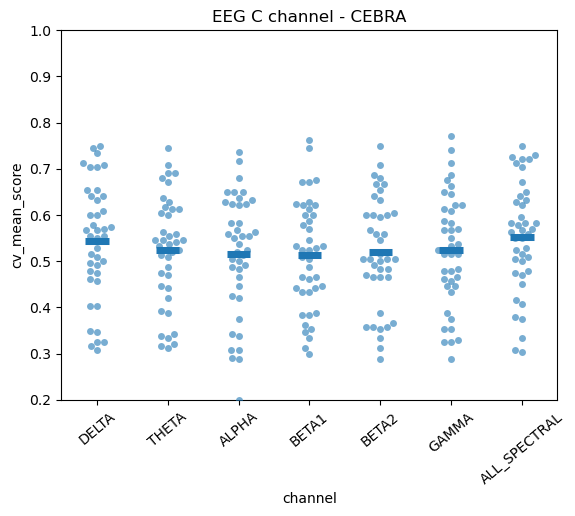

In [101]:
data = subject_accuracy_summary
title = "EEG C channel - CEBRA"  #
g = sns.swarmplot(
    data=data,
    x="channel",
    y="cv_mean_score",
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.2, 1))

df_means = data.groupby(["channel"])["cv_mean_score"].agg("mean").reset_index()
pp = sns.pointplot(
    x="channel",
    y="cv_mean_score",
    data=df_means,
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    order=[
        "DELTA",
        "THETA",
        "ALPHA",
        "BETA1",
        "BETA2",
        "GAMMA",
        'ALL_SPECTRAL'
    ],
)
pp.set_xticklabels(['DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA', 'ALL_SPECTRAL'], rotation=40)

g.set_title(title)